## BI Programmer Analyst Take Home

#### Import Libraries & Setup Engines
I set up an ODBC Data Source called localhost to make connection a bit cleaner 

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sql
import plotly.express as px
import plotly.graph_objects as go 

sql_engine = sql.create_engine('mssql+pyodbc://@localhost')

#### Read the file & write into a SQL Server table 

In [23]:
filename = 'GoodleapSmallSchemaExample.xlsx' 
sheet_dt = {'loan_submission':['timestamp'], 'customer':['created_date', 'last_updated']}

for sheet in sheet_dt: 
    df = pd.read_excel(filename, sheet_name=sheet) 
    sql_engine.execute(f'DROP TABLE IF EXISTS {sheet}') 
    df.to_sql(sheet, sql_engine, index=False)

#### 1. Write a SQL query that gets the latest loan amount and customer credit score for all loans.

In [84]:
query = f"""

WITH latest_loan (loan_id, max_time) AS (
  SELECT loan_id, MAX(timestamp) as max_time
    FROM loan_submission
   GROUP BY loan_id), 

latest_cs (Customer_id, credit_score, rank) AS (
  SELECT Customer_id, credit_score, 
         RANK () OVER ( 
			           PARTITION BY Customer_id
			           ORDER BY last_updated DESC) AS rank 
    FROM customer) 

SELECT ls.loan_id, ls.[loan amount], lcs.credit_score 
  FROM loan_submission ls 
  JOIN latest_loan ll 
    ON ls.loan_id = ll.loan_id 
   AND ls.timestamp = ll.max_time 
  JOIN latest_cs lcs 
    ON ls.customer_id = lcs.Customer_id 
   AND lcs.rank = 1 
 ORDER BY loan_id 

"""
df = pd.read_sql_query(query, sql_engine)
df.head(20)

,loan_id,loan amount,credit_score
0,00589L015,4000,680
1,00589L029,9200,702



#### 2. Write a query that returns the loan amount per stage on a monthly basis year to date. 
Do not show data for incomplete months.


In [106]:
query = f"""

SELECT stage, SUBSTRING(timestamp, 6, 2) as month, SUM([loan amount]) AS [loan amount] 
  FROM loan_submission ls 
 WHERE LEFT(timestamp, 4) = '2022' 
 GROUP BY stage, SUBSTRING(timestamp, 6, 2)
 ORDER BY stage, month

"""
df = pd.read_sql_query(query, sql_engine)
df.head(20)

,stage,month,loan amount
0,1,09,30900
1,2,09,11000
2,3,09,11100
3,4,09,4500
4,5,09,4500
5,6,09,4500



#### 3. We’d like to construct a new metric: loan drift 
Captures how much the loan amount changes as it moves through the pipeline. <br>
How would you go about designing that metric and what questions would you ask the business?


- Perhaps temporal distance from t0 is interesting in addition to stage 
- Need to understand preference of low volatility vs high sensitivity to set temporal/longitudinal frequency 
- Perhaps a variable timeframe slider on an interactive dashboard element would be useful in that case 
- Understand cohorts that may vary differently (homogeneity of variance) 
- Need to understand preference of recall vs precision (how much deviance is meaningful)
- Understand need to control for long-term trends, seasonality, initialization periods, etc. 


#### 4. Write a SQL query that could be charted using a tool like Tableau to provide Loan Drift visibility to the business. 
Clearly state any assumptions made in the analysis


- For expediency , I chose to show a Pythonic example. (I have a significant time constraint)
- This code would calculate the stage/stage ratio for each stage

In [ ]:
dfx = df[['loan_id', 'loan amount', 'stage']]
dfs = [dfx[dfx['stage']==stage] for stage in sorted(df['stage'].unique())]

dfi = dfs[0]

for i in range(len(df['stage'].unique() - 1)): 
    dfi.join(dfs[i+1], on='loan_id', suffixes=f'_{i+1}')
    dfi.loc[:,f'drift_{i+1}'] = round(df[f'loan amount_{i+2}'] / df[f'loan amount_{i+1}'], 2)

dfi.loc[:,f'drift_0'] = round(df[f'loan amount_1'] - df[f'loan amount'], 2) 


#### 5. Describe the type of chart/charts you would provide to visualize loan drift over time. 

- It would look a bit like this, but with less missing data. 
- Also, the y axis would be the normalized drift ratio (calculated above) instead of the nominal loan amount
- With more time, I'd create an interactive dashboard that defaults to showing the most volatile loans, with dropdowns
- Volatility could be ranked using something like Coefficient of Variance (std dev / mean) for each loan 

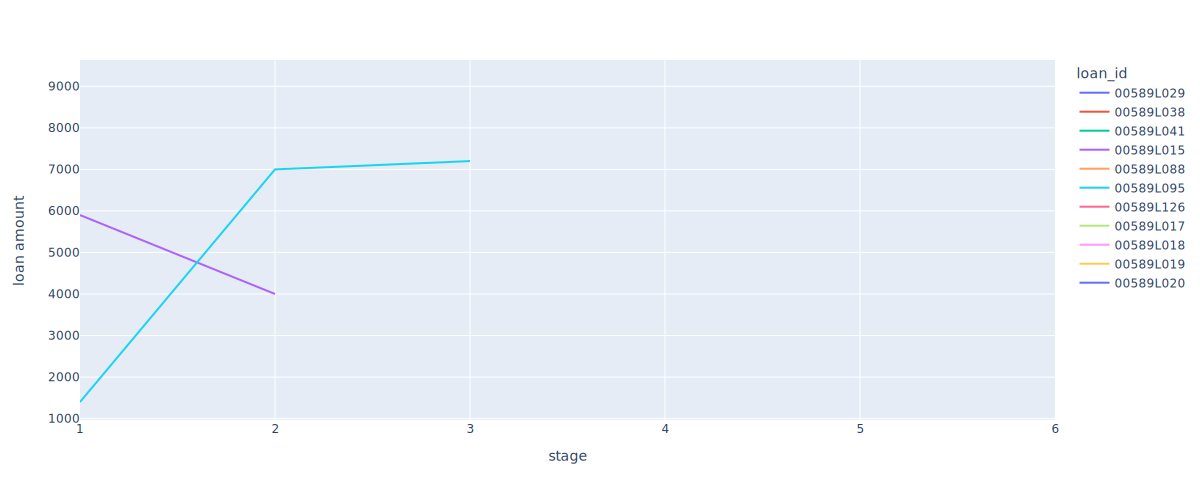

In [126]:
df.sort_values('stage', inplace=True)
fig = px.line(df, x='stage', y='loan amount', color='loan_id', width=1200)
fig.show('svg')

Thanks for reading! 

Luke Simmons - 2022